In [8]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
try:
    # Corrigindo o nome do arquivo de 'facotr' para 'factor'
    df = pd.read_csv('cervical+cancer+risk+factors/risk_factors_cervical_cancer.csv')
    print("Arquivo carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo não encontrado. Por favor, verifique se:")
    print("1. O arquivo 'risk_factor_cervical_cancer.csv' existe no diretório 'cervical+cancer+risk+factors'")
    print("2. O nome do arquivo está escrito corretamente")
    print("3. O arquivo está no caminho correto")
    exit()
except Exception as e:
    print(f"Erro inesperado ao carregar o arquivo: {str(e)}")
    exit()

# Define the columns to be dropped
columns_to_drop = ['Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 
                  'IUD (years)', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                  'First sexual intercourse']

# Drop the specified columns
df_dropped = df.drop(columns=columns_to_drop, errors='ignore')

# Display the first few rows of the modified DataFrame to verify the changes
print("\nPrimeiras linhas do DataFrame modificado:")
print(df_dropped.head())

# Save the modified DataFrame to a new CSV file
try:
    df_dropped.to_csv('risk_factors_cervical_cancer_modified.csv', index=False)
    print("\nArquivo modificado salvo com sucesso!")
except Exception as e:
    print(f"\nErro ao salvar o arquivo modificado: {str(e)}")

Arquivo carregado com sucesso!

Primeiras linhas do DataFrame modificado:
   Age Number of sexual partners Num of pregnancies Smokes  \
0   18                       4.0                1.0    0.0   
1   15                       1.0                1.0    0.0   
2   34                       1.0                1.0    0.0   
3   52                       5.0                4.0    1.0   
4   46                       3.0                4.0    0.0   

  Hormonal Contraceptives  IUD STDs STDs (number) STDs:condylomatosis  \
0                     0.0  0.0  0.0           0.0                 0.0   
1                     0.0  0.0  0.0           0.0                 0.0   
2                     0.0  0.0  0.0           0.0                 0.0   
3                     1.0  0.0  0.0           0.0                 0.0   
4                     1.0  0.0  0.0           0.0                 0.0   

  STDs:cervical condylomatosis  ... STDs:HPV STDs: Number of diagnosis  \
0                          0.0  ...     


Análise para Hinselmann

Melhor valor de k: 4

Distribuição das Classes:
Total de amostras de teste: 172
Positivos (1): 7
Negativos (0): 165

Matriz de Confusão:
[[VN FP]
 [FN VP]]
[[155  10]
 [  7   0]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       165
           1       0.00      0.00      0.00         7

    accuracy                           0.90       172
   macro avg       0.48      0.47      0.47       172
weighted avg       0.92      0.90      0.91       172



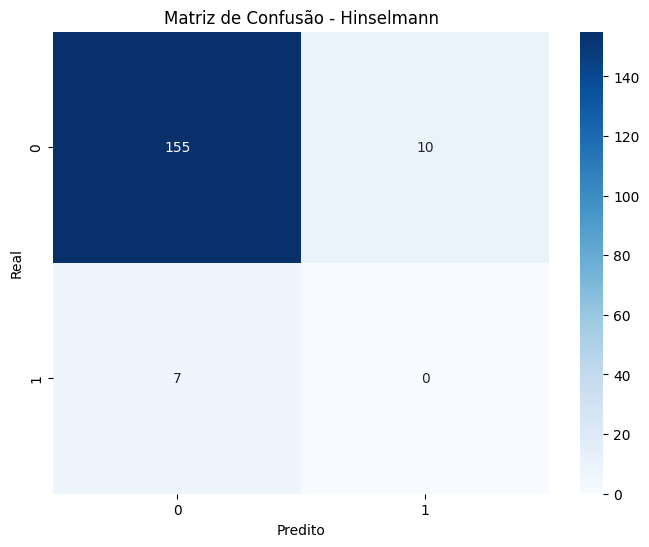


Análise para Schiller

Melhor valor de k: 4

Distribuição das Classes:
Total de amostras de teste: 172
Positivos (1): 15
Negativos (0): 157

Matriz de Confusão:
[[VN FP]
 [FN VP]]
[[135  22]
 [ 12   3]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       157
           1       0.12      0.20      0.15        15

    accuracy                           0.80       172
   macro avg       0.52      0.53      0.52       172
weighted avg       0.85      0.80      0.82       172



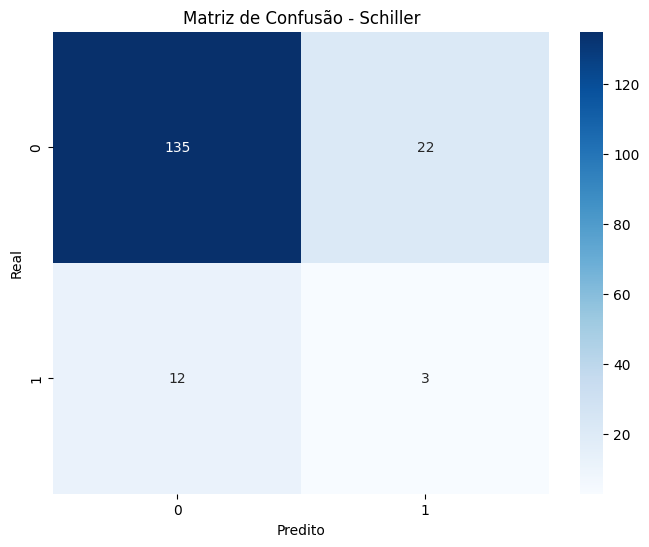


Análise para Citology

Melhor valor de k: 4

Distribuição das Classes:
Total de amostras de teste: 172
Positivos (1): 9
Negativos (0): 163

Matriz de Confusão:
[[VN FP]
 [FN VP]]
[[147  16]
 [  9   0]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       163
           1       0.00      0.00      0.00         9

    accuracy                           0.85       172
   macro avg       0.47      0.45      0.46       172
weighted avg       0.89      0.85      0.87       172



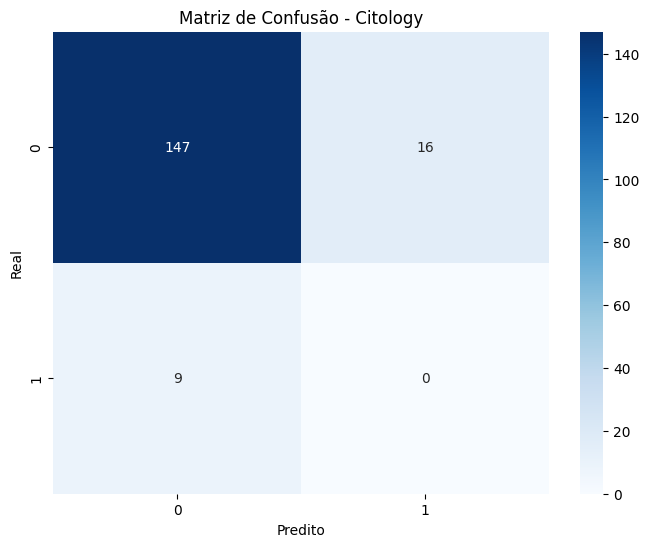


Análise para Biopsy

Melhor valor de k: 4

Distribuição das Classes:
Total de amostras de teste: 172
Positivos (1): 11
Negativos (0): 161

Matriz de Confusão:
[[VN FP]
 [FN VP]]
[[142  19]
 [  8   3]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       161
           1       0.14      0.27      0.18        11

    accuracy                           0.84       172
   macro avg       0.54      0.58      0.55       172
weighted avg       0.89      0.84      0.87       172



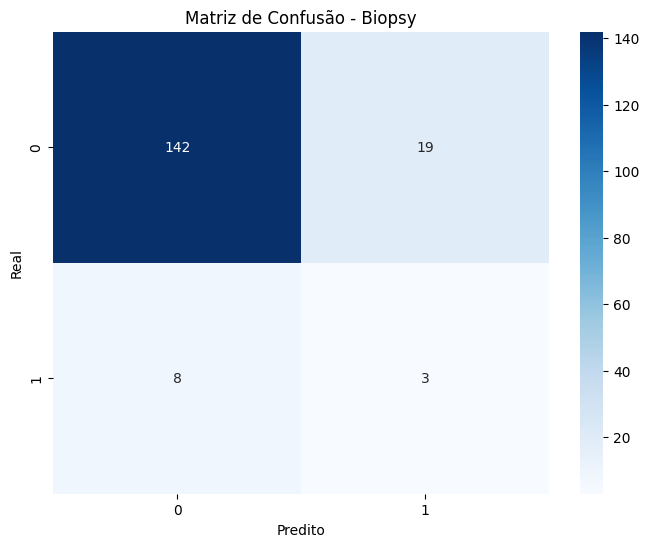


Resumo Final das Performances:

Hinselmann:
Melhor k: 4
Acurácia: 0.9012

Schiller:
Melhor k: 4
Acurácia: 0.8023

Citology:
Melhor k: 4
Acurácia: 0.8547

Biopsy:
Melhor k: 4
Acurácia: 0.8430


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

def plot_confusion_matrix(cm, target_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {target_name}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()

# Tratamento dos dados
df_dropped = df_dropped.replace('?', np.nan)
df_dropped = df_dropped.apply(pd.to_numeric, errors='coerce')
df_dropped = df_dropped.fillna(df_dropped.mean())

# Separar features e targets
X = df_dropped.drop(['Hinselmann', 'Schiller', 'Citology', 'Biopsy'], axis=1)
targets = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

results = {}

for target in targets:
    print(f"\n{'='*50}")
    print(f"Análise para {target}")
    print(f"{'='*50}")
    
    # Preparar dados
    y = df_dropped[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Padronizar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Aplicar SMOTE para balancear as classes
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    # Encontrar melhor valor de k
    param_grid = {'n_neighbors': range(4, 12)}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Treinar KNN com melhor k
    best_k = grid_search.best_params_['n_neighbors']
    print(f"\nMelhor valor de k: {best_k}")
    
    # Criar e treinar modelo com melhor k
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_balanced, y_train_balanced)
    
    # Fazer previsões
    y_pred = knn.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    print("\nDistribuição das Classes:")
    print(f"Total de amostras de teste: {len(y_test)}")
    print(f"Positivos (1): {sum(y_test == 1)}")
    print(f"Negativos (0): {sum(y_test == 0)}")
    
    print("\nMatriz de Confusão:")
    print("[[VN FP]")
    print(" [FN VP]]")
    print(cm)
    
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    # Plotar matriz de confusão
    plot_confusion_matrix(cm, target)
    
    # Armazenar resultados
    results[target] = {
        'model': knn,
        'best_k': best_k,
        'accuracy': knn.score(X_test_scaled, y_test),
        'confusion_matrix': cm
    }

# Resumo final
print("\nResumo Final das Performances:")
print("="*50)
for target, result in results.items():
    print(f"\n{target}:")
    print(f"Melhor k: {result['best_k']}")
    print(f"Acurácia: {result['accuracy']:.4f}")